In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob
from functools import reduce

In [3]:
path = os.getcwd()+'/user_epoch/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

clean = []
csex = []
cage = []
cdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4 : #and 0 in df['phase'].unique() and 1 in df['phase'].unique()
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                 
            cdf.append(df)
            demo_info = f.split("/")[-1].split('.')[0]
            csex.append(re.split('(\d+)',demo_info)[0])
            cage.append(int(re.split('(\d+)',demo_info)[1]))
            clean.append(int(f.split("/")[-1].split('.')[1][1:])) 

KeyboardInterrupt: 

In [3]:
path = os.getcwd()+'/match_c/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

mclean = []
mcsex = []
mcage = []
mcdf = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    if len(df['phase'].unique()) >= 4: #and 0 in df['phase'].unique() and 1 in df['phase'].unique():
        if np.all([np.count_nonzero(df[df['phase']==ph]['hr'].notna()) > 100 for ph in df['phase'].unique()]):
                
                mcdf.append(df)
                demo_info = f.split("/")[-1].split('.')[0]
                
                mclean.append(int(f.split("/")[-1].split('.')[1][1:]))  
                mcsex.append(re.split('(\d+)',demo_info)[0])
                mcage.append(int(re.split('(\d+)',demo_info)[1]))

In [4]:
perss_user = pd.DataFrame(data =  np.array([clean, csex, cage]).T,columns = ['uid', 'sex', 'age'])
match_user = pd.DataFrame(data =  np.array([mclean, mcsex, mcage]).T,columns = ['uid', 'sex', 'age'])
#mu_idx = [np.where(np.array(muid) == i)[0][0] for i in [int(i) for i in match_user[(match_user.sex == 'male')&(match_user.age == '60')]['uid'].iloc[:5].values]]
#pu_idx = np.where(np.array(uid) == int(perss_user[(perss_user.sex=='male')&(perss_user.age=='60')]['uid'].iloc[0]))[0][0]  

In [5]:
perss_user['c'] = 1
match_user['c'] = 1

In [8]:
#match_user.groupby(by=['age','sex']).sum()

In [29]:
matched_idx = []
used = []
for p in range(len(perss_user.groupby(by=['age','sex']).sum())):
     
    val = perss_user.groupby(by=['age','sex']).sum().values[p][0]
    age = perss_user.groupby(by=['age','sex']).sum().index[p][0]
    sex = perss_user.groupby(by=['age','sex']).sum().index[p][1]
    mid = np.random.choice(match_user[(match_user.sex == sex)&(match_user.age == age)&(~match_user.uid.isin(used))].index,val * 5,replace=False)
    for i in match_user[match_user.index.isin(mid)].uid.values:
        used.append(i)
    for i in mid:
        matched_idx.append(i)
#matched_idx = list(set(matched_idx ))  

In [35]:
testdates = []
for i in cdf:
    testdates.append(pd.to_datetime(i.dt.iloc[0]).date())
    
testdatesc = []
for i in matched_idx:
    testdatesc.append(pd.to_datetime(mcdf[i].dt.iloc[0]).date())

In [42]:
ax[0].hist(testdatesc)

(array([ 1., 19., 35., 38., 42., 30., 15., 33., 36., 11.]),
 array([18972. , 18998.6, 19025.2, 19051.8, 19078.4, 19105. , 19131.6,
        19158.2, 19184.8, 19211.4, 19238. ]),
 <BarContainer object of 10 artists>)

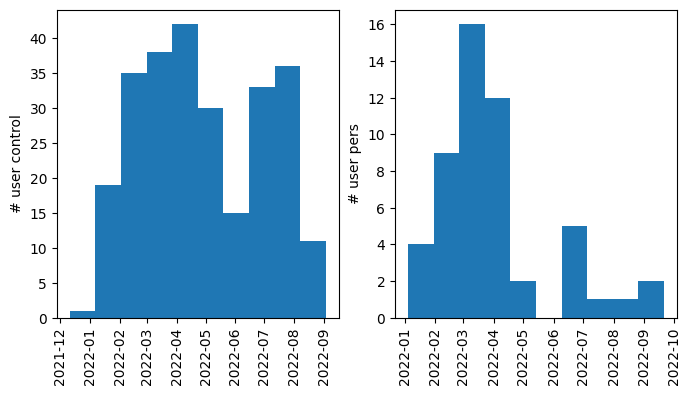

In [44]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist(testdatesc)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel('# user control');
ax[1].hist(testdates)
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylabel('# user pers');

In [45]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(len(elements)- window_size + 1):
        wi_days.append(elements[i:i+window_size])         
    return wi_days

In [46]:
def get_md(subd):
    subd = subd.copy()
    subd['start'] = pd.to_datetime(subd['start'])
    subd = subd[subd['start'].notna()]
    if len(subd) > 0:
        night = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['hr'].dropna()
        day = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['hr'].dropna()
        #rhr_rel = subd[(subd['start'].dt.time < pd.to_datetime('07:00:00').time())&((subd['steps'].isna())|(subd['steps']==0))]['% of MHR'].dropna()
        rhr_rel = subd['rhr'].dropna()
        hr_rel = subd[(subd['start'].dt.time >= pd.to_datetime('07:00:00').time())&((subd['steps'].notna())&(subd['steps']!=0))]['% of MHR'].dropna()
        if len(day) >= 20 and len(night) < 5:
                return 0,0,day.mean(), day.std() #,0, hr_rel.mean()
        elif len(day) >= 20 and len(night) >= 5:
                return night.mean(), night.std(), day.mean(), day.std() #, rhr_rel.mean(), hr_rel.mean()
        else:
            return 0,0,0,0#,0,0
    else:
        return 0,0,0,0#,0,0

In [47]:
mins = []
maxs = []
minw = []
maxw = []
for ui in range(len(cdf)): #np.where(s_i & a_i)[0]
    df = cdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())
    
for ui in matched_idx: #np.where(s_i & a_i)[0]
    df = mcdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    mins.append(df['day_totest'].min())
    maxs.append(df['day_totest'].max())
    minw.append(df['week_totest'].min())
    maxw.append(df['week_totest'].max())

In [48]:
lcu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(cdf)))
lcu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(cdf)))
lcu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(cdf)))
#lcu_rhr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(cdf)))
#lcu_hr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(cdf)))
i =0
for ui in range(len(cdf)):# np.where(s_i & a_i)[0]:
    df = cdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df['day_totest'] = df['date'] - df['dt']
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    

    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds = get_md(df[df['date'].isin(wi_list[wi])])
        lcu_day_mean.loc[lcu_day_mean.index.isin(dtt_list[wi]),i] =  dm
        lcu_night_mean.loc[lcu_night_mean.index.isin(dtt_list[wi]),i] =  nm
        #lcu_rhr_rel.loc[lcu_rhr_rel.index.isin(dtt_list[wi]),i] =  rhrr
        #lcu_hr_rel.loc[lcu_rhr_rel.index.isin(dtt_list[wi]),i] =  hrr
        if dm != 0 and nm != 0:
            lcu_diff.loc[lcu_night_mean.index.isin(dtt_list[wi]),i] = (dm - nm)/dm
    i += 1

In [49]:
lcu_diff = lcu_diff[(lcu_diff.index >= datetime.timedelta(days = -62)) &(lcu_diff.index <= datetime.timedelta(days = 180))]
#lcu_rhr_rel = lcu_rhr_rel[(lcu_rhr_rel.index >= datetime.timedelta(days = -62)) &(lcu_rhr_rel.index <= datetime.timedelta(days = 180))]
lcu_day_mean = lcu_day_mean[(lcu_day_mean.index >= datetime.timedelta(days = -62)) &(lcu_day_mean.index <= datetime.timedelta(days = 180))]
lcu_night_mean = lcu_night_mean[(lcu_night_mean.index >= datetime.timedelta(days = -62)) &(lcu_night_mean.index <= datetime.timedelta(days = 180))]
#lcu_hr_rel = lcu_hr_rel[(lcu_hr_rel.index >= datetime.timedelta(days = -62)) &(lcu_hr_rel.index <= datetime.timedelta(days = 180))]

In [50]:
#lcu_rhr_rel = lcu_rhr_rel.replace(0, np.nan)
#lcu_hr_rel = lcu_hr_rel.replace(0, np.nan)
lcu_night_mean = lcu_night_mean.replace(0, np.nan)
lcu_day_mean = lcu_day_mean.replace(0, np.nan)
lcu_diff = lcu_diff.replace(0,np.nan)

In [51]:
import seaborn as sns

In [96]:
data = lcu_night_mean #- lcu_night_mean[lcu_night_mean.index < pd.Timedelta(days=-7)].mean()
data = lcu_diff - lcu_diff[lcu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)
#data =  lcu_day_mean - lcu_day_mean[lcu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)

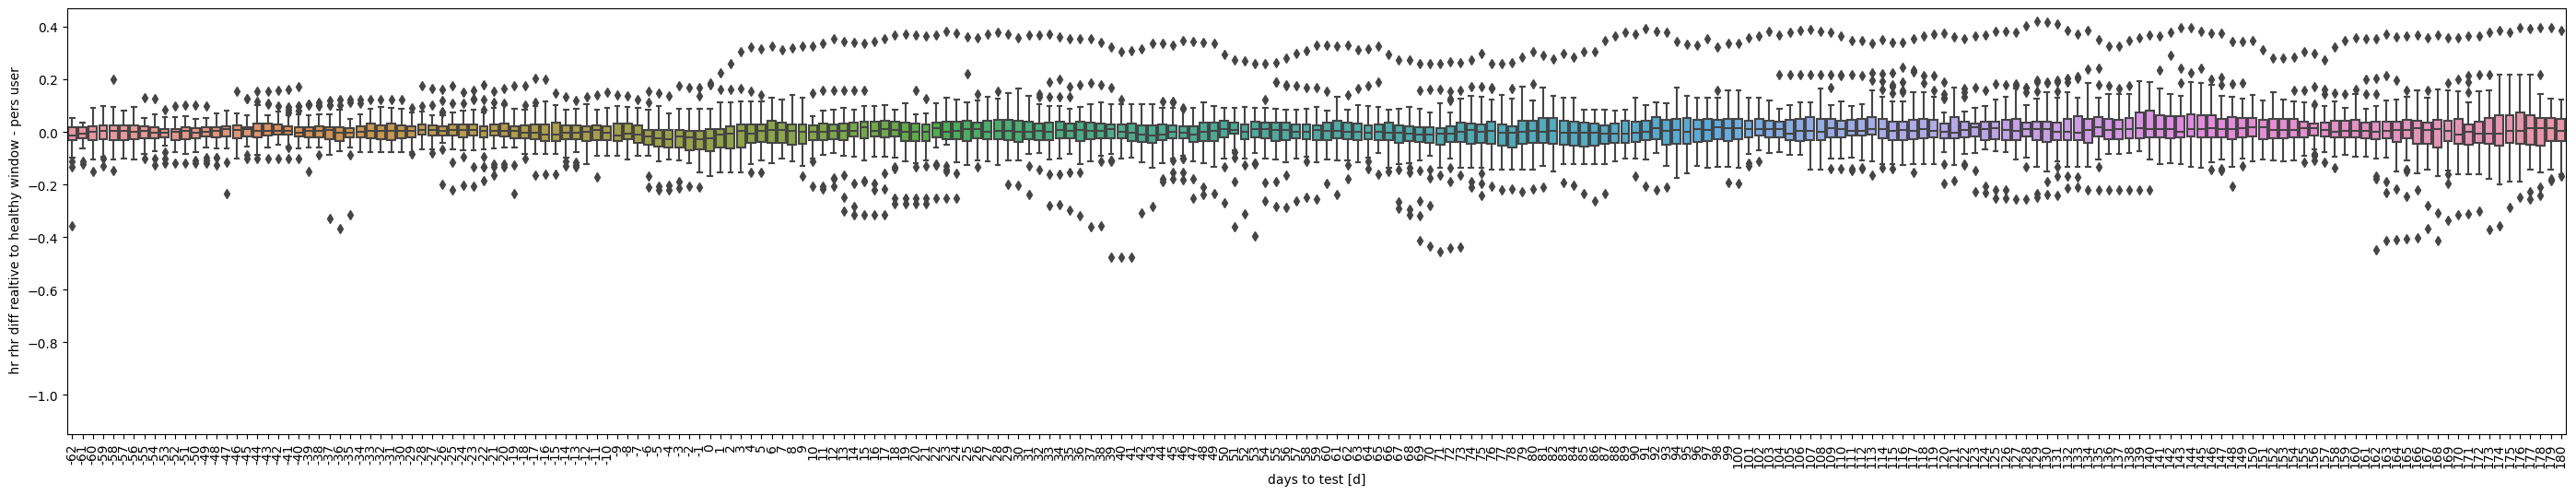

In [107]:
plt.figure(figsize=(35,6))
ax=sns.boxplot(data.T);
#labels = ax.get_xticklabels()
ax.set_xticklabels(data.index.days,rotation = 90);
ax.set_ylim(-1.15,0.47)
ax.set_xlabel('days to test [d]')
ax.set_ylabel(' hr rhr diff realtive to healthy window - pers user');

In [99]:
lcu_diff - lcu_diff[lcu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
-62 days,0.019062,NaN,NaN,-0.357275,0.002667,0.000567,NaN,-0.031165,NaN,-0.096232,...,0.011326,0.032818,-0.046976,0.007993,-0.025912,-0.111987,NaN,-0.034201,-0.029931,-0.017097
-61 days,0.019062,NaN,NaN,0.004657,-0.002212,-0.005067,NaN,-0.034826,NaN,-0.059927,...,0.002031,-0.015058,-0.061848,0.009826,-0.017299,-0.113147,NaN,-0.034201,-0.022417,-0.000129
-60 days,0.019062,NaN,NaN,0.093113,0.004717,-0.001742,NaN,-0.039857,NaN,-0.06869,...,0.005882,0.001555,-0.052456,0.027229,-0.016294,-0.104705,NaN,-0.034201,-0.028939,0.012705
-59 days,0.029514,NaN,NaN,0.098199,-0.008667,0.007101,NaN,-0.042647,NaN,-0.088821,...,0.003144,0.006179,-0.059249,0.014704,-0.036045,-0.102941,NaN,-0.034201,-0.04106,0.025902
-58 days,0.068311,NaN,NaN,0.093635,0.007976,0.014348,NaN,-0.039555,NaN,-0.060221,...,-0.027391,0.009095,-0.048051,0.000436,-0.03893,-0.102941,NaN,-0.034201,-0.032495,0.033354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176 days,NaN,NaN,0.043956,-0.248754,NaN,NaN,-0.059165,-0.039594,0.396648,0.079022,...,-0.030445,0.076293,0.075418,-0.068144,NaN,0.104481,-0.074974,NaN,0.002638,-0.087406
177 days,NaN,NaN,0.042605,-0.256884,NaN,NaN,-0.067322,-0.043248,0.392277,0.059927,...,-0.019947,0.074432,0.066813,-0.091855,NaN,0.113471,-0.059361,NaN,0.025174,-0.064277
178 days,NaN,NaN,0.035131,-0.241635,NaN,NaN,-0.053804,-0.049736,0.397721,0.046918,...,-0.007226,0.086257,0.066813,-0.092879,NaN,0.13482,-0.064888,NaN,0.039988,-0.060395
179 days,NaN,NaN,0.026493,-0.177448,NaN,NaN,-0.041858,-0.04187,0.398184,0.021418,...,-0.009137,0.092589,0.066813,-0.105703,NaN,0.127907,-0.064888,NaN,0.050479,-0.02523


In [ ]:
# plt.figure(figsize=(15,6))
# #plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
# lcu_diffrel = lcu_rhr_rel - lcu_rhr_rel[lcu_rhr_rel.index < pd.Timedelta(days=-7)].mean(axis=0)
# plt.plot(lcu_diffrel.index.days, lcu_diffrel.mean(axis=1))
# plt.xlabel('days to test [d]')
# plt.ylabel('rhr - mean of healthy window');

In [ ]:
# plt.figure(figsize=(15,6))
# #plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
# lcu_diffrel = lcu_diff - lcu_diff[lcu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)
# plt.plot(lcu_diffrel.index.days, lcu_diffrel.mean(axis=1))
# plt.xlabel('days to test [d]')
# plt.ylabel('diff hr rhr - mean of healthy window');

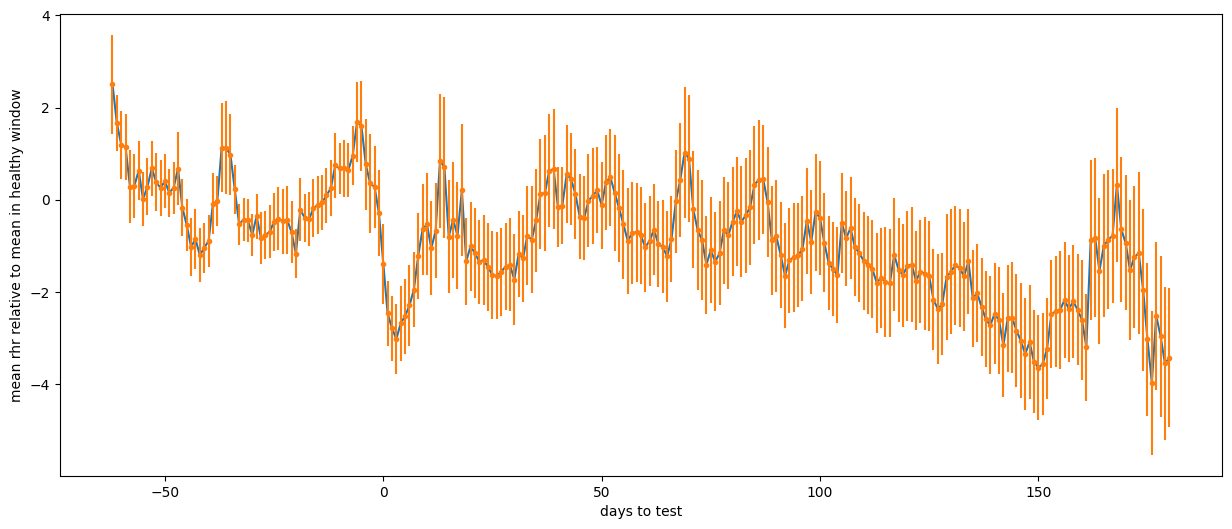

In [63]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
lcumeanrhrrel = lcu_night_mean - lcu_night_mean[lcu_night_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(lcumeanrhrrel.index.days, lcumeanrhrrel.mean(axis=1))
plt.errorbar(lcumeanrhrrel.index.days,lcumeanrhrrel.mean(axis=1),yerr = lcumeanrhrrel.std(axis=1)/np.sqrt(lcumeanrhrrel.notna().sum(axis=1).values), fmt=".")

#plt.plot(lcu_rhr_rel[lcu_rhr_rel.columns[lcu_rhr_rel.notna().sum(axis=0) > 110]].index.days,lcu_rhr_rel[lcu_rhr_rel.columns[lcu_rhr_rel.notna().sum(axis=0) > 110]].mean(axis=1) );
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean rhr relative to mean in healthy window');

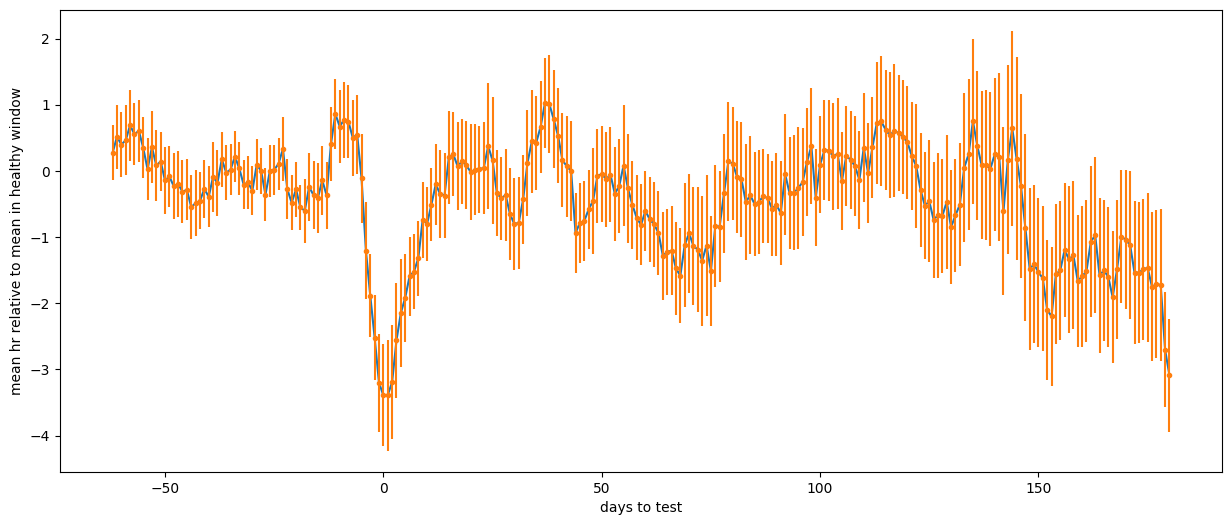

In [64]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
lcumeanhrrel = lcu_day_mean - lcu_day_mean[lcu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(lcumeanhrrel.index.days, lcumeanhrrel.mean(axis=1)) 

plt.errorbar(lcumeanhrrel.index.days,lcumeanhrrel.mean(axis=1),yerr = lcumeanhrrel.std(axis=1)/np.sqrt(lcumeanhrrel.notna().sum(axis=1).values), fmt=".")
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean hr relative to mean in healthy window');

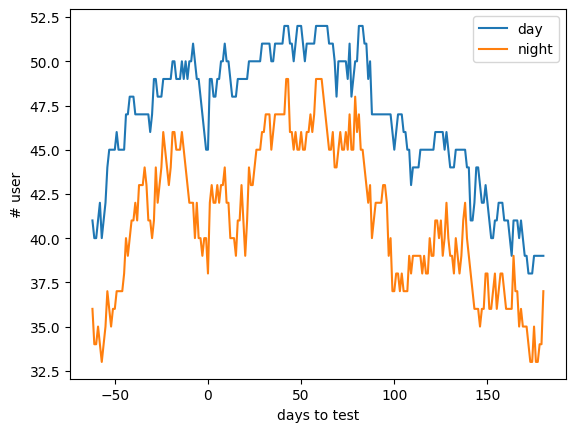

In [65]:
plt.plot(lcu_day_mean.index.days,lcu_day_mean.notna().sum(axis=1))
plt.plot(lcu_night_mean.index.days,lcu_night_mean.notna().sum(axis=1))
plt.legend(['day','night']);
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('# user');

In [66]:
mu_day_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mcdf)))
mu_night_mean = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mcdf)))
mu_diff = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mcdf)))
#mu_rhr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mcdf)))
#mu_hr_rel = pd.DataFrame(index = pd.timedelta_range(min(mins),max(maxs)), columns = range(len(mcdf)))
i = 0
for ui in matched_idx:
    df = mcdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    mis_row = []
    for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
        mis_row.append([
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, dt, np.nan, np.nan, np.nan, dt - df['dt'].unique()[0], np.nan, np.nan, np.nan])
    if len(mis_row) > 0:
        df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))
    
    
    #df['day_totest'] = df['date'] - df['dt']
    wi_list = sliding_window(df['date'].unique(),7)
    dtt_list = sliding_window(df['day_totest'].unique(),7)
    for wi in range(len(wi_list)):
        nm, ns, dm, ds,  = get_md(df[df['date'].isin(wi_list[wi])])
        mu_day_mean.loc[mu_day_mean.index.isin(dtt_list[wi]),i] =  dm
        mu_night_mean.loc[mu_night_mean.index.isin(dtt_list[wi]),i] =  nm
        #mu_rhr_rel.loc[mu_rhr_rel.index.isin(dtt_list[wi]),i] =  rhrr
        #mu_hr_rel.loc[mu_rhr_rel.index.isin(dtt_list[wi]),i] = hrr
        if dm != 0 and nm != 0:
            mu_diff.loc[mu_night_mean.index.isin(dtt_list[wi]),i] = (dm - nm)/dm
    i += 1
        

In [67]:
mu_diff = mu_diff[(mu_diff.index >= datetime.timedelta(days = -62)) &(mu_diff.index <= datetime.timedelta(days = 180))]
#mu_rhr_rel = mu_rhr_rel[(mu_rhr_rel.index >= datetime.timedelta(days = -62)) &(mu_rhr_rel.index <= datetime.timedelta(days = 180))]
#mu_hr_rel = mu_hr_rel[(mu_hr_rel.index >= datetime.timedelta(days = -62)) &(mu_hr_rel.index <= datetime.timedelta(days = 180))]
mu_day_mean = mu_day_mean[(mu_day_mean.index >= datetime.timedelta(days = -62)) &(mu_day_mean.index <= datetime.timedelta(days = 180))]
mu_night_mean = mu_night_mean[(mu_night_mean.index >= datetime.timedelta(days = -62)) &(mu_night_mean.index <= datetime.timedelta(days = 180))]

In [73]:
mu_night_mean = mu_night_mean.replace(0, np.nan)
mu_day_mean = mu_day_mean.replace(0, np.nan)
mu_diff = mu_diff.replace(0,np.nan)

In [92]:
data = mu_night_mean - mu_night_mean[mu_night_mean.index < pd.Timedelta(days=-7)].mean()
data = mu_diff - mu_diff[mu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)
#data =  mu_day_mean #- mu_day_mean[mu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)

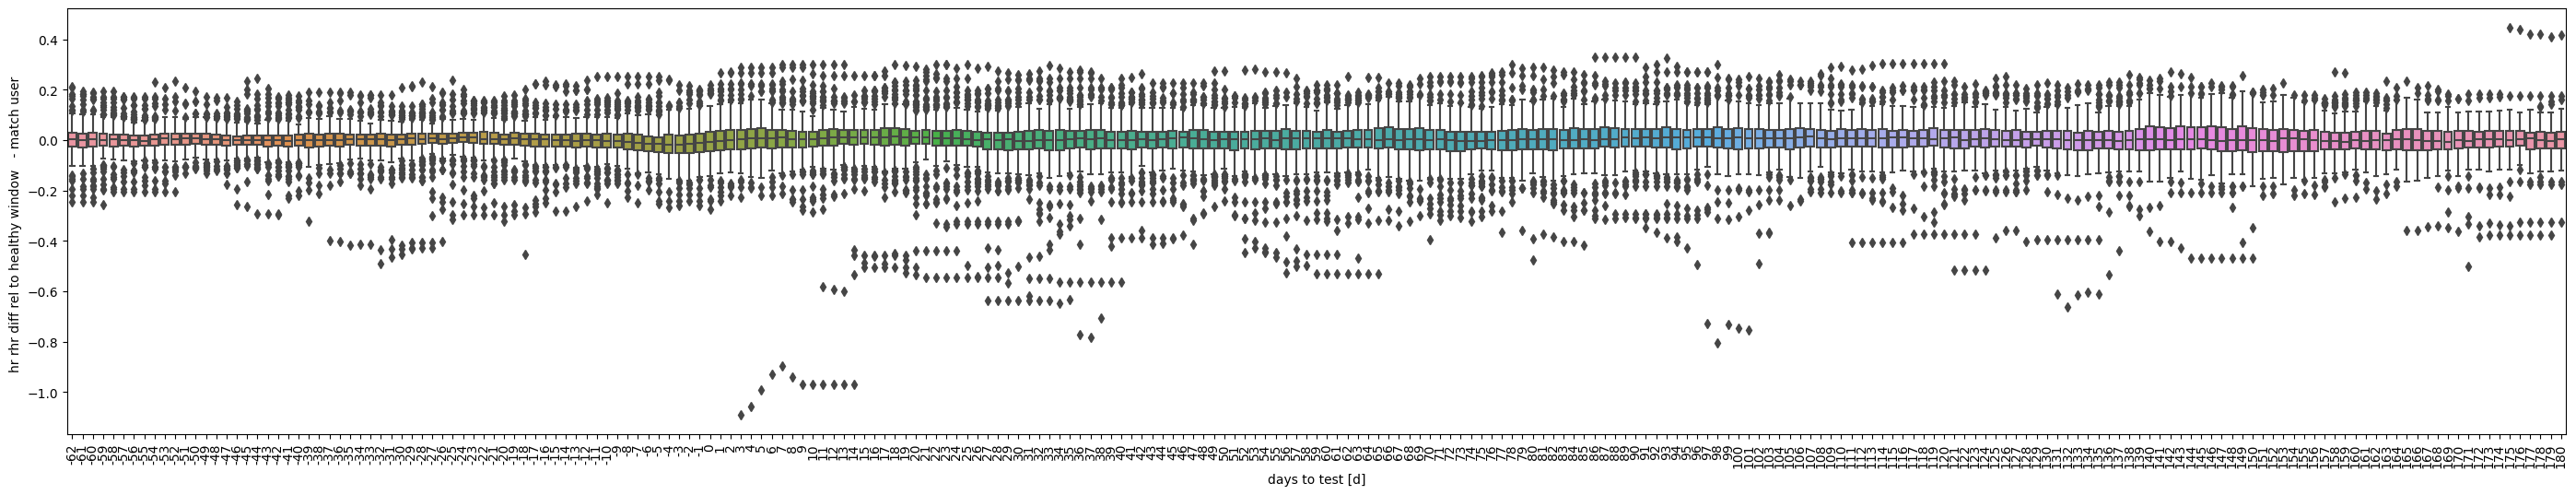

In [93]:
plt.figure(figsize=(35,6))
ax=sns.boxplot(data.T);
#labels = ax.get_xticklabels()
ax.set_xticklabels(data.index.days,rotation = 90);
ax.set_xlabel('days to test [d]')
ax.set_ylabel('hr rhr diff rel to healthy window   - match user ');

In [ ]:
# a = 60
# s_i = (np.array(csex) == 'female') | (np.array(csex) == 'male')
# a_i = np.array(cage) == a 

# puser = np.array(clean)[np.where(s_i & a_i)[0]]

# ms_i = (np.array(mcsex) == 'female') | (np.array(mcsex) == 'male')
# ma_i = np.array(mcage) == a 

# muser = np.array(mclean)[np.where(ms_i & ma_i)[0]]

In [ ]:
# plt.figure(figsize=(15,6))
# plt.plot(mu_diff.index.days,mu_diff.mean(axis=1));

# plt.plot(lcu_diff.index.days,lcu_diff.mean(axis=1));
# #plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
# #plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
# plt.xlabel('days to test')
# plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
# plt.ylabel('mean relative difference of hr and rhr');

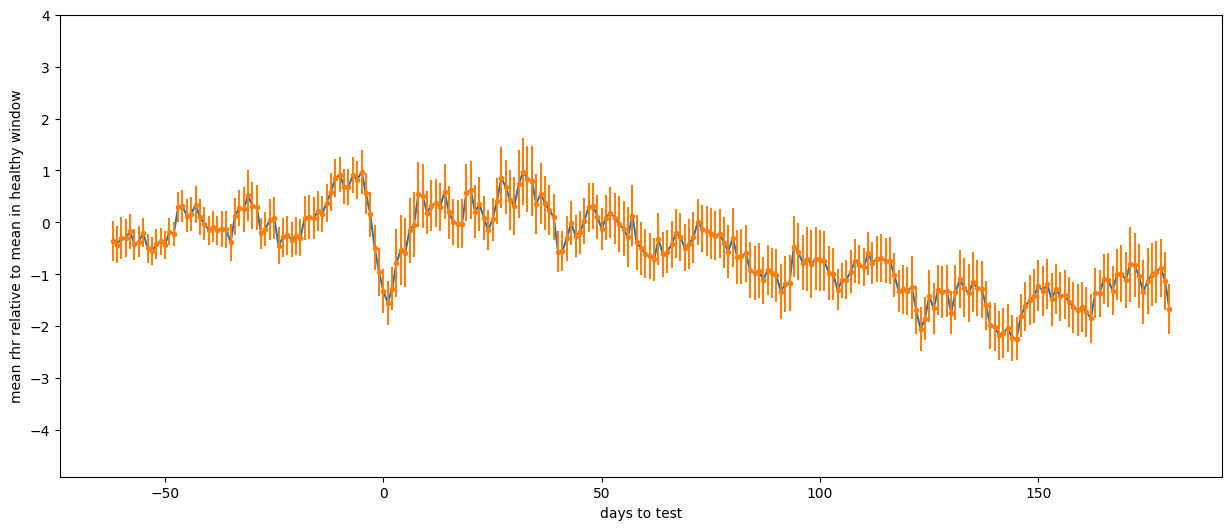

In [87]:
plt.figure(figsize=(15,6))
mumeanrhrrel = mu_night_mean - mu_night_mean[mu_night_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanrhrrel.index.days, mumeanrhrrel.mean(axis=1))
plt.errorbar(mumeanrhrrel.index.days,mumeanrhrrel.mean(axis=1),yerr = mumeanrhrrel.std(axis=1)/np.sqrt(mumeanrhrrel.notna().sum(axis=1).values), fmt=".")
plt.ylim(-4.9,4)
plt.xlabel('days to test') 
plt.ylabel('mean rhr relative to mean in healthy window');

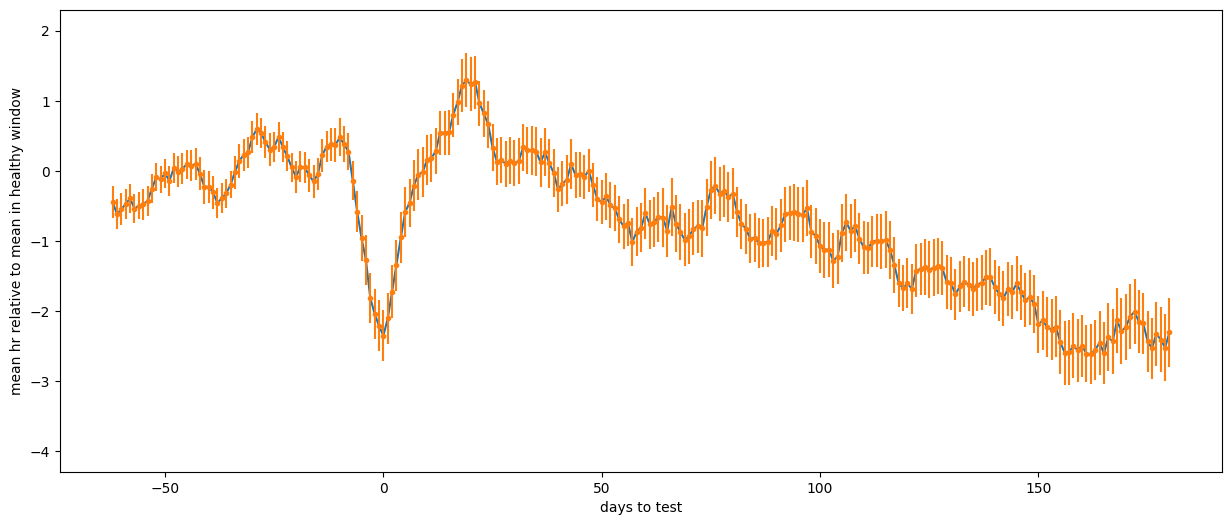

In [90]:
plt.figure(figsize=(15,6))
mumeanhrrel = mu_day_mean - mu_day_mean[mu_day_mean.index < pd.Timedelta(days=-7)].mean(axis=0)
plt.plot(mumeanhrrel.index.days, mumeanhrrel.mean(axis=1))
plt.errorbar(mumeanhrrel.index.days,mumeanhrrel.mean(axis=1),yerr = mumeanhrrel.std(axis=1)/np.sqrt(mumeanhrrel.notna().sum(axis=1).values), fmt=".")
plt.ylim(-4.3,2.3)
plt.xlabel('days to test') 
plt.ylabel('mean hr relative to mean in healthy window');

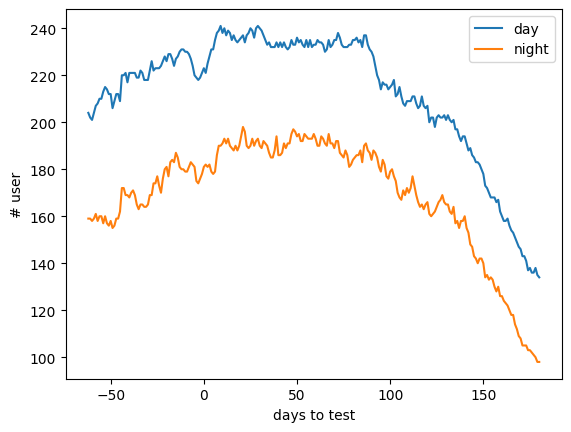

In [91]:
plt.plot(mu_day_mean.index.days,mu_day_mean.notna().sum(axis=1))
plt.plot(mu_night_mean.index.days,mu_night_mean.notna().sum(axis=1))
plt.legend(['day','night']);
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('# user');

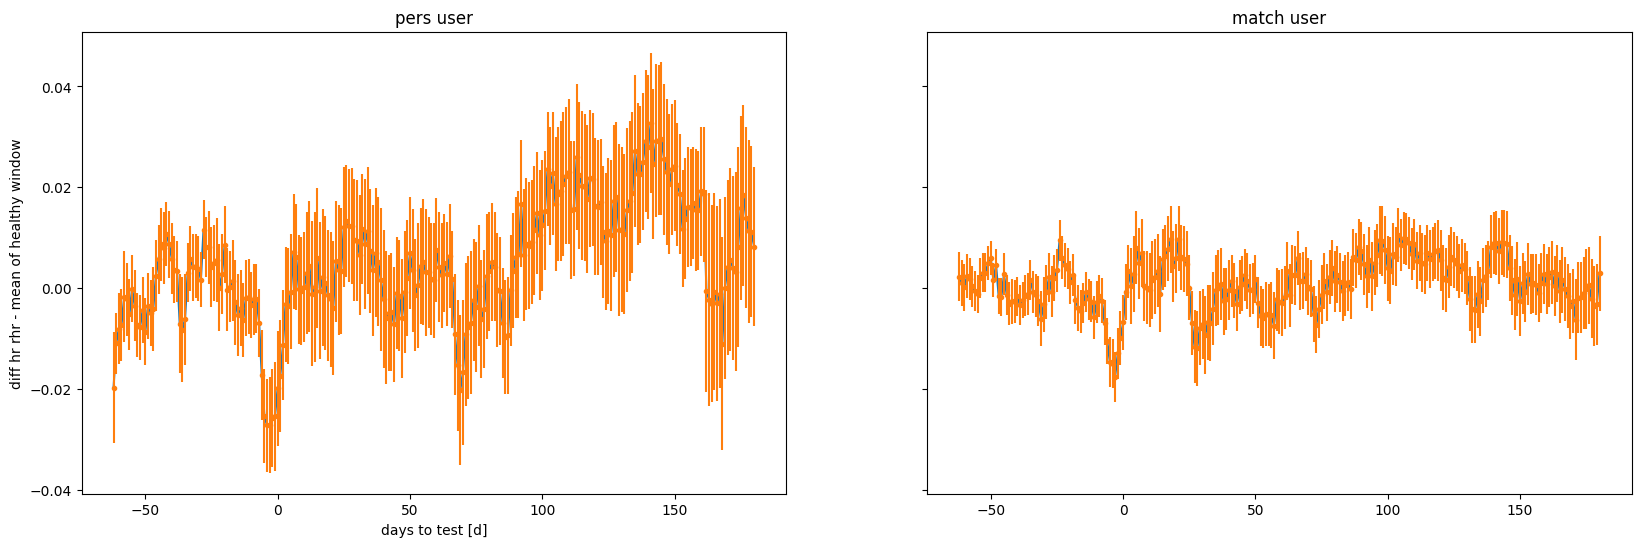

In [117]:
fig,ax=plt.subplots(1,2,figsize=(20,6),sharex=True,sharey=True)
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
lcu_diffrel = lcu_diff - lcu_diff[lcu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)
ax[0].plot(lcu_diffrel.index.days, lcu_diffrel.mean(axis=1))
ax[0].errorbar(lcu_diffrel.index.days,lcu_diffrel.mean(axis=1),yerr = lcu_diffrel.std(axis=1)/np.sqrt(lcu_diffrel.notna().sum(axis=1).values), fmt=".")
mu_diffrel = mu_diff - mu_diff[mu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)

ax[1].plot(mu_diffrel.index.days, mu_diffrel.mean(axis=1))
ax[1].errorbar(mu_diffrel.index.days,mu_diffrel.mean(axis=1),yerr = mu_diffrel.std(axis=1)/np.sqrt(mu_diffrel.notna().sum(axis=1).values), fmt=".")
ax[0].set_xlabel('days to test [d]')
ax[0].set_ylabel('diff hr rhr - mean of healthy window');
ax[0].set_title('pers user')
ax[1].set_title('match user');

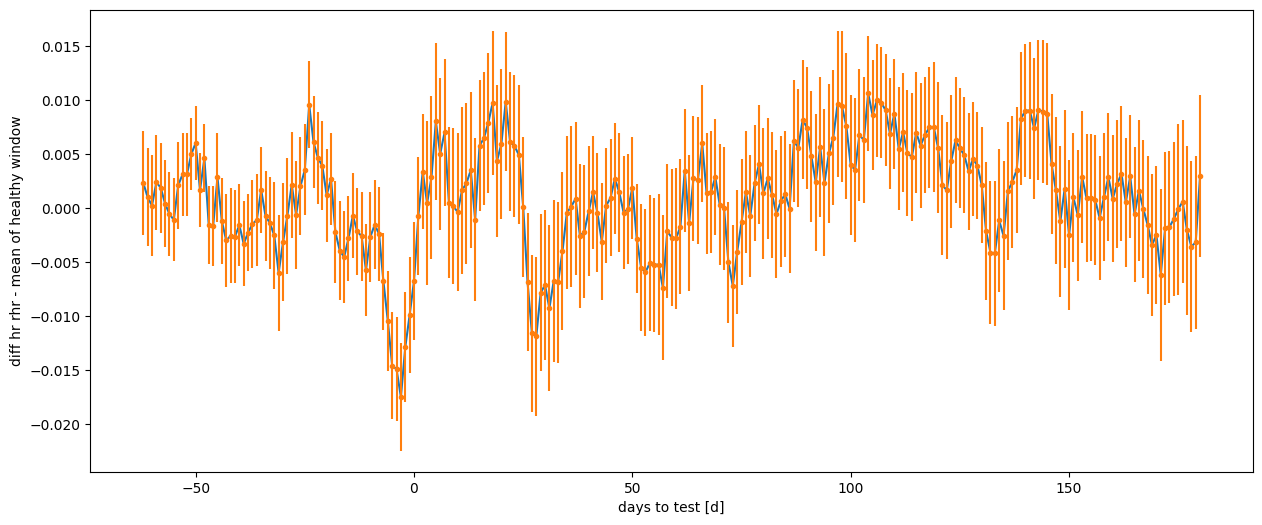

In [112]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );
mu_diffrel = mu_diff - mu_diff[mu_diff.index < pd.Timedelta(days=-7)].mean(axis=0)

plt.plot(mu_diffrel.index.days, mu_diffrel.mean(axis=1))
plt.errorbar(mu_diffrel.index.days,mu_diffrel.mean(axis=1),yerr = mu_diffrel.std(axis=1)/np.sqrt(mu_diffrel.notna().sum(axis=1).values), fmt=".")

plt.xlabel('days to test [d]')
plt.ylabel('diff hr rhr - mean of healthy window');

In [ ]:
plt.figure(figsize=(15,6))
#plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1) );

plt.plot(lcu_rhr_rel.index.days,lcu_rhr_rel.mean(axis=1) );
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean rhr as % to max hr ');

In [ ]:
plt.plot(lcu_rhr_rel.index.days,lcu_rhr_rel.notna().sum(axis=1))

In [ ]:
plt.figure(figsize=(15,6))
#plt.plot(mu_hr_rel.index.days,mu_hr_rel.mean(axis=1) );

plt.plot(lcu_hr_rel.index.days,lcu_hr_rel.mean(axis=1) );
#plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
#plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
plt.xlabel('days to test')
#plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
plt.ylabel('mean hr as % to max hr ');

In [ ]:
plt.plot(lcu_hr_rel.index.days,lcu_hr_rel.notna().sum(axis=1))

In [ ]:
plt.figure(figsize=(15,6))
#plt.plot(mu_hr_rel.index.days,mu_hr_rel.mean(axis=1) );

plt.plot(lcu_diff.index.days,lcu_diff.mean(axis=1) );

In [ ]:
# plt.figure(figsize=(20,6))
# plt.plot(mu_rhr_rel.index.days,mu_rhr_rel.mean(axis=1)-mu_rhr_rel[mu_rhr_rel.index.days < -14].mean(axis=1).mean());

# plt.plot(lcu_rhr_rel.index.days,lcu_rhr_rel.mean(axis=1)-lcu_rhr_rel[lcu_rhr_rel.index.days < -14].mean(axis=1).mean());
# #plt.errorbar(mu_diff.index.days,mu_diff.mean(axis=1),yerr=mu_diff.std(axis=1)/np.sqrt(mu_diff.notna().sum(axis=1).values), fmt=".")
# #plt.xticks( df_cu_diff.index,labels=[str(i) for i in df_cu_diff.index.days//7]);
# plt.xlabel('days to test')
# plt.legend(['matched positive cohort', 'user w persisting symtpoms'])
# plt.ylabel('mean rhr as % to max hr ');

## High act

In [180]:
mu_ha = pd.DataFrame(index = range(-8,26), columns = range(len(matched_idx)))
lcu_ha = pd.DataFrame(index = range(-8,26), columns = range(len(cdf)))

In [181]:
for ui in range(len(cdf)):
    gb = cdf[ui].groupby(['week_totest','day_of_week']).sum()
    gb = gb[(gb.index >= (-8,0))&(gb.index < (26,0))]
    fil = gb['steps'] > 10000
    lcu_ha.loc[fil.groupby('week_totest').sum().index,ui] = fil.groupby('week_totest').sum().values

i = 0 
for ui in matched_idx:
    
    gb = mcdf[ui].groupby(['week_totest','day_of_week']).sum()
    gb = gb[(gb.index >= (-8,0))&(gb.index < (26,0))]
    fil = gb['steps'] > 10000
    mu_ha.loc[fil.groupby('week_totest').sum().index,i] = fil.groupby('week_totest').sum().values
    i += 1

Text(0.5, 0, 'weeks to test')

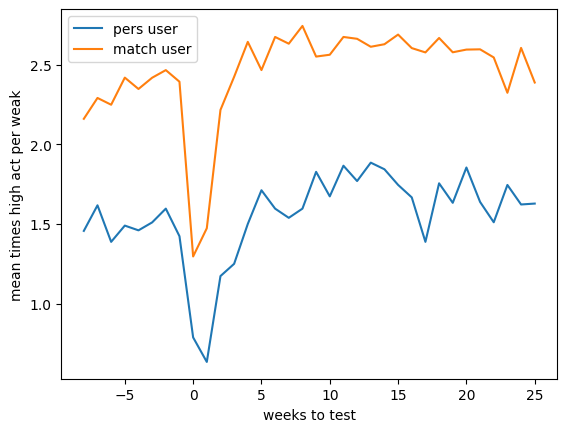

In [189]:
plt.plot(lcu_ha.mean(axis=1))
plt.plot(mu_ha.mean(axis=1))
plt.legend(['pers user', 'match user'])
plt.ylabel('mean times high act per weak')
plt.xlabel('weeks to test')

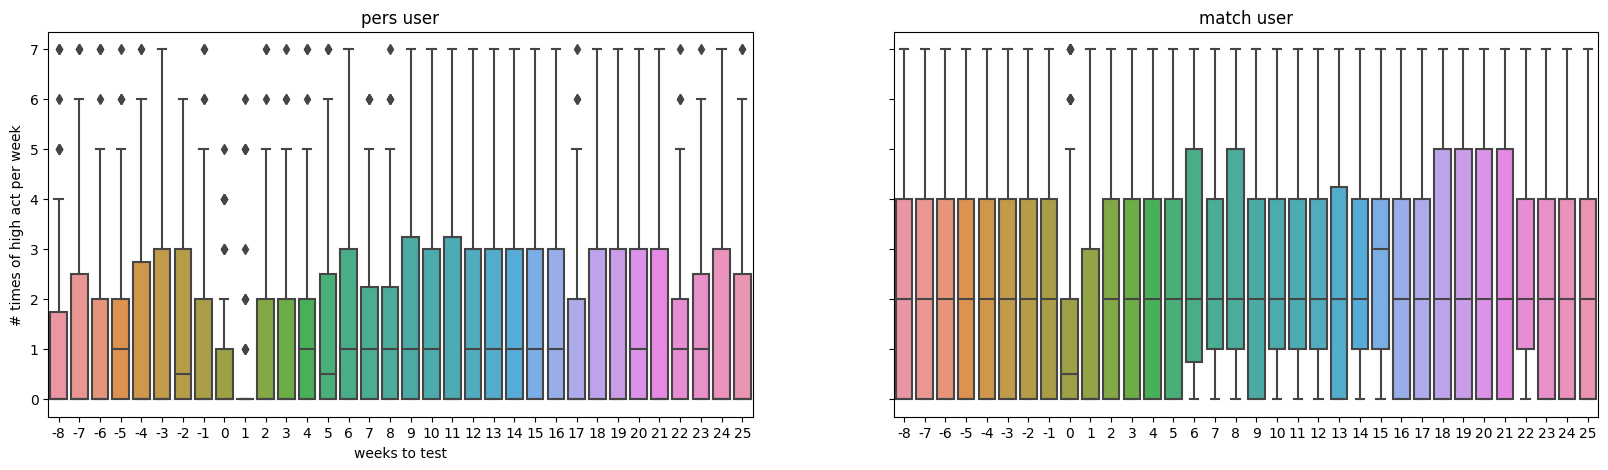

In [198]:
fig,ax = plt.subplots(1,2,figsize=(20,5),sharex=True,sharey=True)
sns.boxplot(lcu_ha.T,ax = ax[0])
sns.boxplot(mu_ha.T,ax = ax[1])
ax[0].set_ylabel('# times of high act per week')
ax[0].set_xlabel('weeks to test')
ax[1].set_title('match user')
ax[0].set_title('pers user');

## HR STEPS

In [ ]:
m_agg = []
for ui in np.where(ms_i & ma_i)[0] :
    df = mcdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    m_agg.append(d_agg)

In [ ]:
l_agg = []
for ui in np.where(s_i & a_i)[0] :
    df = cdf[ui]
    df['dt'] = pd.to_datetime(df['dt'])
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    # group by day and hourly - sum up steps and take mean of heart rate
    # per day 24 time bins with steps summed up and mean of heart rate

    #for du in range(len(df_lcu[0])): 
    d = df.copy()
    d['start'] = pd.to_datetime(d['start'])
    d['steps'] = d['steps'].fillna(0)
    d['steps'] = d['steps'] + 1

    df_aggv = pd.merge(d[['start','hr','rhr', '% of MHR', 'sleep']].set_index('start').resample('60min').mean().reset_index(),d[['start','steps']].set_index('start').resample('60min').sum().reset_index(),how='outer',on='start')
    d_agg = pd.merge(df_aggv, d[['start','date','day_of_week','weekend','dt','day_totest','week_totest', 'phase', 'source','id']].set_index('start').resample('60min').first().reset_index(),how='outer',on='start')
    l_agg.append(d_agg)

In [ ]:
z_min_hr = []
z_max_hr = []
z_min_steps = []
z_max_steps = []
for df in m_agg:
    df['steps'] = df['steps'] - 4
    h_wind = df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        z_min_hr.append(df['hr_z'].min())
        z_max_hr.append(df['hr_z'].max())
        z_min_steps.append(df['steps_z'].min())
        z_max_steps.append(df['steps_z'].max())
        
for df in l_agg:
    df['steps'] = df['steps'] - 4
    h_wind = df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        z_min_hr.append(df['hr_z'].min())
        z_max_hr.append(df['hr_z'].max())
        z_min_steps.append(df['steps_z'].min())
        z_max_steps.append(df['steps_z'].max())

In [ ]:
minhr = min(z_min_hr)
maxhr = max(z_max_hr)
minsteps = min(z_min_steps)
maxsteps = max(z_max_steps)

In [ ]:
stepbin = np.linspace(minsteps-0.1, maxsteps+0.1, 20)
hrbin = np.linspace(minhr-0.1, maxhr+0.1, 20)

In [ ]:
#fig, ax = plt.subplots(2,4,figsize=(16,8),sharex = True, sharey=True)
histpps = []
for df in m_agg:
    df['steps'] = df['steps'] - 4
    h_wind =  df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        histpp = np.zeros((19,19,4))
        for ph in [0,1,2,3]:      
            dph = df[df['phase'] == ph]
            dfhist = dph[['hr_z','steps_z']].dropna()
         
            n, b = np.histogram(dfhist['hr_z'],bins = hrbin)
            #ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
            
            n, b = np.histogram(dfhist['steps_z'],bins = stepbin)
            #ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
            
            H, xedges, yedges = np.histogram2d(dfhist['steps_z'], dfhist['hr_z'],bins=(stepbin, hrbin),normed=True)
            areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
            histpp[:,:,ph] = H*areas
        histpps.append(histpp)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey=True)
for ph in [0,1,2,3]:
    hph = np.zeros((19,19, len(histpps)))
    for i in range(len(histpps)):
        hph[:,:,i] = histpps[i][:,:,ph]
    prob = np.nanmean(hph,axis =2)
    X, Y = np.meshgrid(xedges, yedges)
     
    im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))
    ax[ph].set_xlabel('z transformed steps')
    ax[ph].set_ylabel('z transformed hr')
cbar = plt.colorbar(im);
cbar.ax.set_ylabel('log (probability)', rotation=270);

In [ ]:
#fig, ax = plt.subplots(2,4,figsize=(16,8),sharex = True, sharey=True)
histpps = []
for df in l_agg:
    df['steps'] = df['steps'] - 4
    h_wind =  df[(df['week_totest'] < -2) & (df['week_totest'] > -8)]
    if len(h_wind['week_totest'].unique()) >= 2 and len(h_wind[h_wind['hr'].notna()]) >= 10:
        hrm = h_wind['hr'].mean()
        hrstd = h_wind['hr'].std()
        stm = h_wind['steps'].mean()
        ststd = h_wind['steps'].std()
        df['hr_z'] = (df['hr'] - hrm )/ hrstd
        df['steps_z'] = (df['steps'] - stm )/ ststd
        histpp = np.zeros((19,19,4))
        for ph in [0,1,2,3]:      
            dph = df[df['phase'] == ph]
            dfhist = dph[['hr_z','steps_z']].dropna()
         
            n, b = np.histogram(dfhist['hr_z'],bins = hrbin)
            #ax[0,ph].stairs(n/len(dfhist['hr_z']), hrbin, fill=False)
            
            n, b = np.histogram(dfhist['steps_z'],bins = stepbin)
            #ax[1,ph].stairs(n/len(dfhist['steps_z']), stepbin, fill=False)
            
            H, xedges, yedges = np.histogram2d(dfhist['steps_z'], dfhist['hr_z'],bins=(stepbin, hrbin),normed=True)
            areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
            histpp[:,:,ph] = H*areas
        histpps.append(histpp)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(16,8),sharex = True, sharey=True)
for ph in [0,1,2,3]:
    hph = np.zeros((19,19, len(histpps)))
    for i in range(len(histpps)):
        hph[:,:,i] = histpps[i][:,:,ph]
    prob = np.nanmean(hph,axis =2)
    X, Y = np.meshgrid(xedges, yedges)
     
    im = ax[ph].pcolormesh(X, Y, np.log(prob.T ))
    ax[ph].set_xlabel('z transformed steps')
    ax[ph].set_ylabel('z transformed hr')
cbar = plt.colorbar(im);
cbar.ax.set_ylabel('log (probability)', rotation=270);